# PyMCによる項目反応理論の実装

[項目反応理論（IRT: Item Response Theory）](https://ja.wikipedia.org/wiki/%E9%A0%85%E7%9B%AE%E5%BF%9C%E7%AD%94%E7%90%86%E8%AB%96)は，TOEFLなどのような試験の各設問の難易度，および回答者の能力を推測するためのモデルである．基本的な考え方は，回答者の能力と設問の難易度をパラメータとするロジスティック関数をある設問の正解確率と見なし，試験の回答状況は定義された正解確率をパラメータとするベルヌーイ分布に従う，というものである．

パラメータの推定方法は最尤推定法が一般的であるが，バージョン4にアップデートされた[PyMC](https://www.pymc.io/welcome.html)の練習をかねて，MCMCで項目反応理論のパラメータ推定をやってみた．

In [1]:
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

## データセットの読み込み
練習用データとして，20ある設問に対して2000名の受験者の回答結果を記したデータを用意した．
各行が各受験者の回答状況に対応しており，設問1（Q1）〜設問20（Q20）に対する回答結果が，正解1，不正解0として記されている．
このデータは疑似データであり，[試験の数理](https://qiita.com/takuyakubo/items/43d56725952e67032b49)を参考に生成した．

データ（`dataset/item_response.tsv`）の中身は以下の通りである．

In [2]:
df = pd.read_table('dataset/item_response.tsv', sep='\t', header=0, index_col=0)
df.head()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Q17,Q18,Q19,Q20
participant,,,,,,,,,,,,,,,,,,,,
0,0,0,0,1,1,0,0,1,0,1,0,0,1,1,0,0,0,1,1,0
1,1,1,0,1,1,1,0,0,1,0,1,1,1,1,0,1,0,0,1,0
2,1,0,0,1,1,0,1,1,1,1,0,1,1,0,0,0,0,1,0,1
3,1,1,0,1,1,1,1,0,0,0,1,1,1,1,1,1,0,1,1,1
4,1,1,0,1,0,1,1,0,1,1,1,1,1,1,1,1,1,1,0,1


この疑似データは，項目反応理論の3パラメータロジスティックモデルで生成している．すなわち，回答者$i$の設問$j$に対する正解確率$p_{i,j}$は回答者の能力パラメータ$\theta_i$と設問パラメータ$a_j$（識別力），$b_j$（難易度），$c_j$（当て推量）で以下のように表現できると仮定している．

$$
p_{i,j} = c_j + (1-c_j) \frac{1}{1+exp(- a_j(\theta_i - b_j))}
$$

生成に用いた設問のパラメータは`dataset/item_params.tsv`，回答者の能力パラメータは`dataset/participant_params.tsv`で確認できる．

In [3]:
# 設問のパラメータを確認
item_df = pd.read_table('dataset/item_params.tsv', sep='\t', header=0)
item_df.index = [f'Q{qid}' for qid in range(1, 21)]
item_df

,a,b,c
Q1,0.530947,-1.126938,0.262671
Q2,0.778774,0.440435,0.016508
Q3,0.851570,1.997521,0.078272
Q4,0.496084,-1.853463,0.310627
Q5,0.592267,-0.531258,0.134943
Q6,0.827886,1.180413,0.169449
Q7,0.686584,0.559992,0.363648
Q8,0.735757,1.890666,0.340324
Q9,0.366514,0.357466,0.198492
Q10,0.504268,-1.591176,0.140980


In [4]:
# 回答者の能力パラメータ
participant_df = pd.read_table('dataset/participant_params.tsv', sep='\t', header=0)
participant_df.head(10)

,theta
0,-0.846466
1,-0.215250
2,0.367516
3,0.283451
4,2.386955
5,0.300458
6,-0.204278
7,-0.249474
8,0.080900
9,1.191649


上記回答者の能力パラメータ$\theta$と設問パラメータ$a$，$b$，$c$が未知と仮定して，それらを回答結果データ（`df`）とPyMCを使って推定するのが今回のタスクとなる．

## データの前処理

生の回答結果データ`df`は横持ちのデータになっているので，PyMCで処理しづらい．そこで`df`に格納されたデータを整然データ（tidy data）化しておく．

In [5]:
# tidy data化
response_df = pd.melt(df.reset_index(),
                      id_vars='participant', var_name='question', value_name='response')
response_df.head()

,participant,question,response
0,0,Q1,0
1,1,Q1,1
2,2,Q1,1
3,3,Q1,1
4,4,Q1,1


次に，`response_df`を構成する回答者情報，設問名をコード化して取り出しておく．この処理を行っておくことで，PyMCでモデルを書くときにfor文などを使わずに各種パラメータをベクトルとしてうまく扱えるようになる．

In [6]:
# participants[participant_idx] is equal to response_df['participant']
participant_idx, participants = pd.factorize(response_df['participant'])

# questions[question_idx] is equal to response_df['question']
question_idx, questions = pd.factorize(response_df['question'])

`participant_idx`および`quesiton_idx`は，それぞれ`response_df`の各レコード（行）に対応する回答者および質問のIDが格納されている．
`participants`および`questions`はnumpyの配列であるため，ファンシーインデックスとしてが使える．

## モデリング

データの準備が整ったので，モデルの定義，事後分布からのサンプリングを行う．今回用いるデータは3パラメータロジスティックモデルに従うようデータを生成したが，そのことは知らないふりをして **2パラメータロジスティックモデル** を仮定してモデリングを行う．

項目反応理論では基本的なモデルとして，1パラメータ，2パラメータ，3パラメータのロジスティックモデルが提案されている．パラメータが増えるごとに複雑な状況を想定できる．2パラメータのロジスティックモデルでは，
* 回答者
    - 能力パラメータ $\theta$（実数）
* 設問
    - 識別力パラメータ $a$（正の値）
    - 難易度パラメータ $b$（実数）

の存在を仮定している．その上で，回答者$i$の能力を$\theta_i$，設問$j$の識別力，難易度，当て推量を$a_j$，$b_j$としたとき，回答者$i$の設問$j$に対する回答の正誤$r_{i,j}$は以下に従うと考える：

$$
p_{i,j} = \frac{1}{1 + exp(-a_j(\theta_i - b_j))} \\
r_{i,j} \sim Bernoulli(p_{ij})
$$

これから，$a$，$b$，$\theta$の事後分布をPyMCによって推定する．
パラメータの事前分布は適当に

$$
a \sim HalfNormal(1) \\
b \sim N(0,1) \\
\theta \sim N(0, 1)
$$

とすることにする．上記の仮定をPyMCでモデル化すると，下記のように書ける．

In [7]:
coords = {'participant': participants, 'question': questions}
model = pm.Model(coords=coords)

with model:  
    # 個人の能力（回答者ごとに割り当て）
    theta = pm.Normal('theta', mu=0, sigma=1, dims='participant')
    # 問題の識別力（設問ごとに割り当て）
    a = pm.HalfNormal('a', sigma=1, dims='question')
    # 問題の難易度（設問ごとに割り当て）
    b = pm.Normal('b', mu=0, sigma=1, dims='question')
    
    # 2パラメータロジスティックモデル（2PLM）
    p = 1 / (1 + pm.math.exp(-1 * a[question_idx] * (theta[participant_idx] - b[question_idx])))

    y_obs = pm.Bernoulli('y_obs', p=p, observed=response_df.response)

参考として，定義したモデルをDAGとして可視化しておく．

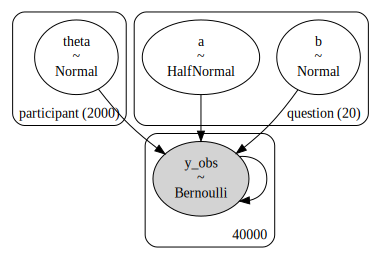

In [8]:
pm.model_to_graphviz(model)

## サンプリング
ここまでくれば，あとはMCMCでサンプリングするだけ．以下のコードでMCMCを実行．

In [9]:
with model:
    # デフォルトだとサンプリング数が1000なので，多めに
    idata = pm.sample(draws=3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, a, b]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 201 seconds.


事後分布のフォレストプロットを表示．回答者は2000名もいるので，設問のパラメータのみ表示する．

array([<AxesSubplot:title={'center':'95.0% HDI'}>,
       <AxesSubplot:title={'center':'r_hat'}>], dtype=object)

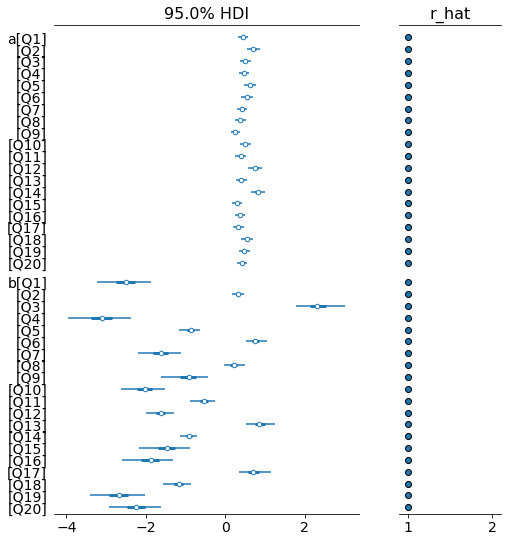

In [10]:
az.plot_forest(idata, var_names=['a', 'b'],
               combined=True, hdi_prob=0.95, r_hat=True)

推定結果の統計情報を表示してみる．

In [11]:
summary = az.summary(idata, round_to=3)

In [12]:
# パラメータa
summary['a[Q1]':'a[Q20]']

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[Q1],0.443,0.064,0.323,0.560,0.001,0.001,4658.249,6545.090,1.001
a[Q2],0.703,0.084,0.545,0.863,0.001,0.001,3934.094,5545.668,1.001
a[Q3],0.501,0.071,0.368,0.633,0.001,0.001,4213.180,5569.369,1.001
a[Q4],0.461,0.063,0.344,0.583,0.001,0.001,4988.436,6346.457,1.000
a[Q5],0.611,0.081,0.462,0.765,0.001,0.001,3797.666,5064.476,1.001
a[Q6],0.542,0.077,0.398,0.687,0.001,0.001,3764.156,5833.289,1.001
a[Q7],0.414,0.067,0.288,0.538,0.001,0.001,4599.046,5794.894,1.001
a[Q8],0.374,0.072,0.244,0.511,0.001,0.001,4693.109,5494.258,1.000
a[Q9],0.247,0.062,0.129,0.361,0.001,0.001,3884.925,4007.212,1.000
a[Q10],0.505,0.073,0.370,0.643,0.001,0.001,4247.580,5801.152,1.001


In [13]:
# パラメータb
summary['b[Q1]':'b[Q20]']

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b[Q1],-2.539,0.358,-3.192,-1.884,0.005,0.004,4895.879,6828.738,1.001
b[Q2],0.323,0.078,0.176,0.469,0.001,0.001,9451.046,7946.289,1.000
b[Q3],2.348,0.321,1.742,2.919,0.005,0.003,4428.009,5848.205,1.001
b[Q4],-3.135,0.409,-3.912,-2.403,0.006,0.004,5076.265,6133.681,1.001
b[Q5],-0.886,0.131,-1.133,-0.651,0.002,0.001,4639.785,5162.062,1.001
b[Q6],0.766,0.136,0.530,1.029,0.002,0.001,4667.299,5751.743,1.001
b[Q7],-1.647,0.281,-2.176,-1.161,0.004,0.003,4955.545,5319.148,1.001
b[Q8],0.213,0.136,-0.031,0.470,0.002,0.002,10093.293,5423.484,1.000
b[Q9],-0.969,0.316,-1.547,-0.427,0.005,0.004,5157.487,4565.617,1.000
b[Q10],-2.049,0.291,-2.613,-1.548,0.004,0.003,4418.912,5566.085,1.001


期待値を見ると，最も難易度が高いと推定される設問はQ3．時点はQ13，Q17あたり．逆に最も簡単と推定されたのはQ1，Q4，Q19あたりか．

答え合わせのため，下のパラメータを格納した`item_df`を表示．

In [14]:
item_df

,a,b,c
Q1,0.530947,-1.126938,0.262671
Q2,0.778774,0.440435,0.016508
Q3,0.851570,1.997521,0.078272
Q4,0.496084,-1.853463,0.310627
Q5,0.592267,-0.531258,0.134943
Q6,0.827886,1.180413,0.169449
Q7,0.686584,0.559992,0.363648
Q8,0.735757,1.890666,0.340324
Q9,0.366514,0.357466,0.198492
Q10,0.504268,-1.591176,0.140980


推定結果と比較すると，絶対値は外れているものの，大小関係は大体合っている？

推定がまともかどうか調べるために，設問の真の難易度と推定された設問の難易度（期待値），回答者の真の能力値と推定された能力値の相関を調べてみる．

In [15]:
from scipy.stats import pearsonr

In [16]:
# 設問の真の難易度
b_real = item_df.b.values

# 設問の難易度の推定値
b_predicted = summary['b[Q1]':'b[Q20]']['mean'].values

b_coef, _ = pearsonr(b_real, b_predicted)
print('coef for question difficulty:', b_coef)

coef for question difficulty: 0.8103580927387857


In [17]:
# 設問の真の難易度
theta_real = participant_df.theta.values

# 設問の難易度の推定値
theta_predicted = summary['theta[0]':'theta[1999]']['mean'].values

theta_coef, _ = pearsonr(theta_real, theta_predicted)
print('coef for participant capability:', theta_coef)

coef for participant capability: 0.6958024869607706


問題の難易度も回答者の能力も，真の値と中程度以上の相関があるようだ．まあまあ良いモデリングができているのではないだろうか（PyMCの使い方が合っているか，やや不安だが）．